In [1]:
library(data.table)
## Assessing the quality of the genes in our remaining cells
generate_matrix = F
matrix_destination = "matrix.cellQC.rds"
source("load_matrix.R")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parS

## Filter Genes

If we were to plot the total number of (non-zero) genes per cell in a histogram, we would expect a normal distribution with long tails.

For high-seq depth, we would see something like this

 ![hemb_feat](https://hemberg-lab.github.io/scRNA.seq.course/14-exprs-qc_files/figure-html/total-features-hist-1.png)
 
 where a minimum cut-off line of 7000 genes is set to remove the cells with smaller gene libraries that are likely indicative of poor quality cells.
 
For low-seq depth data, such as what *we* are dealing with, our distribution looks like this:


FALSE  TRUE 
  106    26 

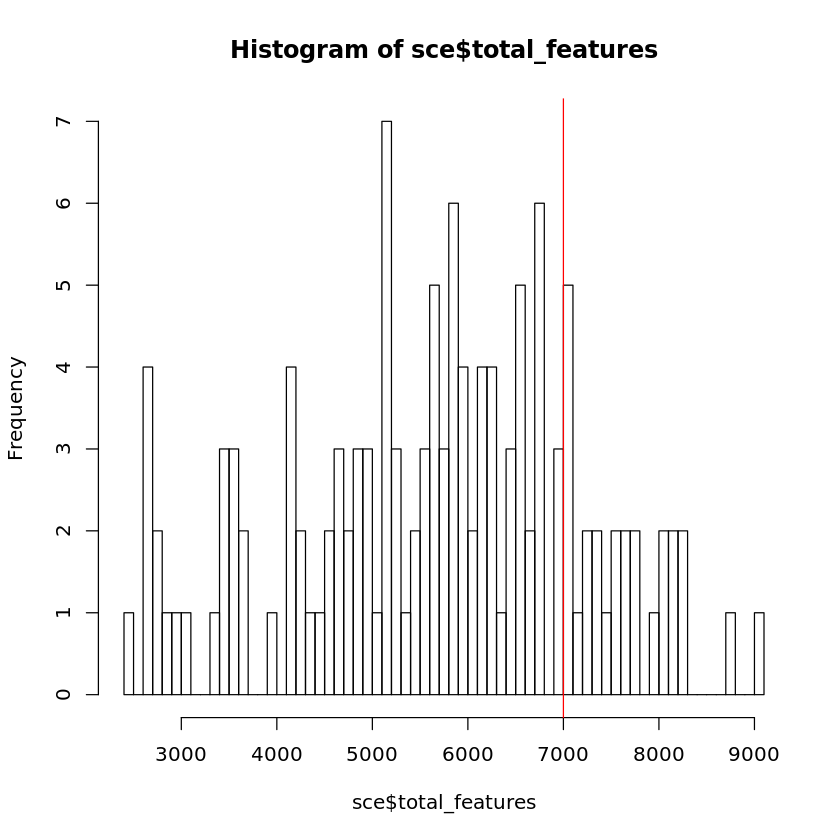

In [2]:
hist(sce$total_features, breaks=70)
abline(v = 7000, col = "red")

table(sce$total_features > 7000)

where just by applying the same threshold we would be left with only 13 cells. Note also that the high variability in the "distribution" due to there being only 192 cells in total.

Regardless of how noisy it appears, there may still be a signal to explore at more acceptable threshold. 


#### Contending Issues: Gene Detectability

 1. Some genes may only exist in cells at low counts. This could mean very low expression, but we must filter above a noise threshold to determine significance. Filtering by this could produce a row of zeroes depending upon if we filter by:

   * **Individual cell-basis:** We zero-out only the individual transcript counts for specific cells if below a minumum expected threshold.
   * **Overall gene-bases:** We zero-out a whole gene if the total transcript counts across all cells are below a minumum expected threshold.
   
 2. Some genes that are known to exist in the source sample are simply not detected by the sequencing platform ("allelic drop-outs"). These often result in a row of zeroes and must be removed since there is no useful comparison that can be derived from them.
 
 3. Some genes only exist in only a limited number of cells. Depending on how high the number of UMI counts, they could be significant genes that outline rare cell types, or they could just be noise. We must determine a good minimum threshold of cells that our genes should be expressed by
   
#### Aims

 * Find a threshold of significance for the lowest number of cells that a gene can appear in.
 * Find a threshold of significance for the lowest number of observeable counts for a gene:
     * Cell-by-cell basis
     * Overall gene basis
     
##### Notes:

 * sce\$total_counts -- is total counts per cell
 * sce\$total_features -- is total genes per cell (or number of non-zero counts per cell)



 First let us look at the quality of the annotations that our gene transcripts have to find any inconsistencies 

In [3]:
message(sprintf("We have %5.0f     ENSMUS IDs, of which %5.0f are unique.",
    length(names(sce)), length(unique(sort(names(sce))))
))

message(sprintf("We have %5.0f       Gene IDs, of which %5.0f are unique.",
                length(rowData(sce)$external_gene_name), 
                length(unique(sort(rowData(sce)$external_gene_name)))
))

message(sprintf("We have %5.0f Transcript IDs, of which %5.0f are unique.",
                length(rowData(sce)$external_transcript_name),
                length(unique(sort(rowData(sce)$external_transcript_name)))
))


We have 21070     ENSMUS IDs, of which 21070 are unique.
We have 21070       Gene IDs, of which 21041 are unique.
We have 21070 Transcript IDs, of which 21048 are unique.


There appears to be a discrepancy of 22 transcripts. Let us examine them.

In [4]:
vec <- rowData(sce)$external_transcript_name
filter_duplicates <- rownames(sce) %in% names(
    sce[duplicated(vec) | duplicated(vec, fromLast=TRUE),]
)

# Table of the culprits
fair <- rowData(sce[filter_duplicates,])
name_fair <- names(fair)

mat <- matrix(unlist(fair), ncol=length(name_fair))
colnames(mat) <- names(fair)
mat <- data.frame(mat)

out_table <- data.table(mat)
out_table <- out_table[,c(9,1,16)]
colnames(out_table) <- c("Ensemble_89", "Ensemble_91", "Total_Counts")
out_table

Ensemble_89,Ensemble_91,Total_Counts
ENSMUSG00000045713,NA,1
ENSMUSG00000071567,NA,1
ENSMUSG00000079489,NA,6
ENSMUSG00000090286,NA,5
ENSMUSG00000093501,NA,1
ENSMUSG00000093561,NA,3
ENSMUSG00000093760,NA,1
ENSMUSG00000094114,NA,8
ENSMUSG00000094518,NA,22
ENSMUSG00000095367,NA,2


These genes are very poorly expressed, with no more than 22 total counts across all cells. 

A look through the ensembl database reveals also that all of these genes have been retired:

In [5]:
getexpr = function(s,g){substring(s,g,g+attr(g,'match.length')-1)}
matcher <- '<div class="lhs">Status</div><div class="rhs"><p>([^<]*)</p>'

checkStatus <- function(rname){
    
    url_name <- paste(
        'http://www.ensembl.org/Mus_musculus/Gene/Idhistory?g=', rname,
        sep=""
    )
    page <- readLines(url_name)
    
    datalines <- grep(matcher, page, value=T)
    gg = gregexpr(matcher,datalines)
    matches = mapply(getexpr,datalines,gg)
    result = gsub(matcher,'\\1',matches)
    names(result) = NULL

    return(result)
}

alleg <- list()
for (ENS in fair$feature_id){
    alleg <- rbind(alleg, c(ENS, checkStatus(ENS)))
}
colnames(alleg) <- c("Gene", "Status")
alleg

Gene,Status
ENSMUSG00000045713,Retired (see below for possible successors)
ENSMUSG00000071567,Retired (see below for possible successors)
ENSMUSG00000079489,Retired (see below for possible successors)
ENSMUSG00000090286,Retired (see below for possible successors)
ENSMUSG00000093501,Retired (see below for possible successors)
ENSMUSG00000093561,Retired (see below for possible successors)
ENSMUSG00000093760,Retired (see below for possible successors)
ENSMUSG00000094114,Retired (see below for possible successors)
ENSMUSG00000094518,Retired (see below for possible successors)
ENSMUSG00000095367,Retired (see below for possible successors)


We should remove these genes from the analysis if we wish to make sense of our data.

In [6]:
# Remove the low-covered genes
sce2 <- sce[(!(rowData(sce)$ensembl_gene_id %in% mat[order(mat$external_gene_name),]$ensembl_gene_id)),]

tab <- rbind(dim(sce), dim(sce2))
rownames(tab) <- c("Before GF", "After GF")
colnames(tab) <- c("Num Genes", "Num Cells")
tab

,Num Genes,Num Cells
Before GF,21070,132
After GF,21048,132


One note of caution that was avoided in the last step is that if we filtered out any genes with total counts < 20 (as suggested by the poor depth of the retired genes), we would have lost half our data!

To show just how sensitive our data is to filtering at the gene level, we will explore different filtering thresholds:


## Gene Filtering

#### Methods

  1. We can define whether a gene is *detectable* or not by defining the minimum number of cells a gene must exist in after first being filtered for a total count of that gene against all cells.
 
  e.g. A sequencing threshold of 100 and minimum of 2 cells
  
  For each gene we sum their counts over all cells, and if the total is higher than 100, then we count how many cells these counts are distributed over where if it is over 2 cells, we keep it.
  
  2. Another approach is to do a by-cell threshold of 100 instead of total gene counts. This method is more stringent in filtering out genes that have a large abundance of counts in only a single cell. Whether or not it is significant to have a high signal from a single cell, is the question. 
  
Let us first evaluate (1) over a range of minimum gene limits and sequencing thresholds.

In [123]:
sce <- calculateQCMetrics(sce2)

# These methods need fine tuning for the c_genes and c_cells.
#  - make sure you are actually calculating the right thing!
#

filterGeneRowsRange <- function(min_genes, min_seq)
{
    table <- data.frame()
    
    for (g in min_genes){
        for (s in min_seq){
            c_genes <- sum(rowSums(counts(sce)) >= s) >= g)
            c_cells <- sum(colSums(counts(sce)) >= s) >= g)
            table <- rbind(table, c(s, g, c_genes, c_cells))
            #message(sprintf("%4.0f cells with >= %5.0f seq-depth and >= %3.0f genes", cells, s, g))
        }
    }
    colnames(table) <- c("SeqDep", "MinGene", "NumGenes", "NumCells")
    return(table)
}


filterGeneSingleRange <- function(min_genes, min_seq)
{
    table <- data.frame()
    
    for (g in min_genes){
        for (s in min_seq){
            c_genes <- sum(counts(sce) >= s) >= g)
            c_cells <- sum(colSums(counts(sce) >= s) >= g)
            table <- rbind(table, c(s, g, c_genes, c_cells))
            #message(sprintf("%4.0f cells with >= %5.0f seq-depth and >= %3.0f genes", cells, s, g))
        }
    }
    colnames(table) <- c("SeqDep", "MinGene", "NumGenes", "NumCells")
    return(table)
}


results <- filterGeneRowsRange(seq(1,10,1), 
    append(seq(1, 9, 1), append(seq(10, 90, 10), seq(100, 500, 20)))
)

Warning message:
“Removed 200 rows containing missing values (geom_path).”

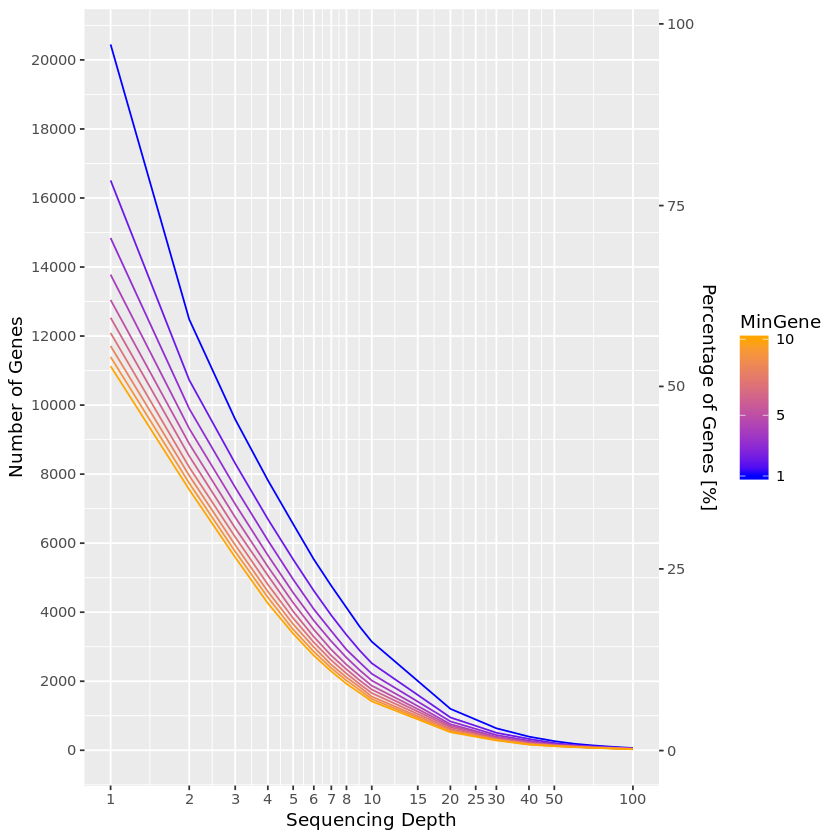

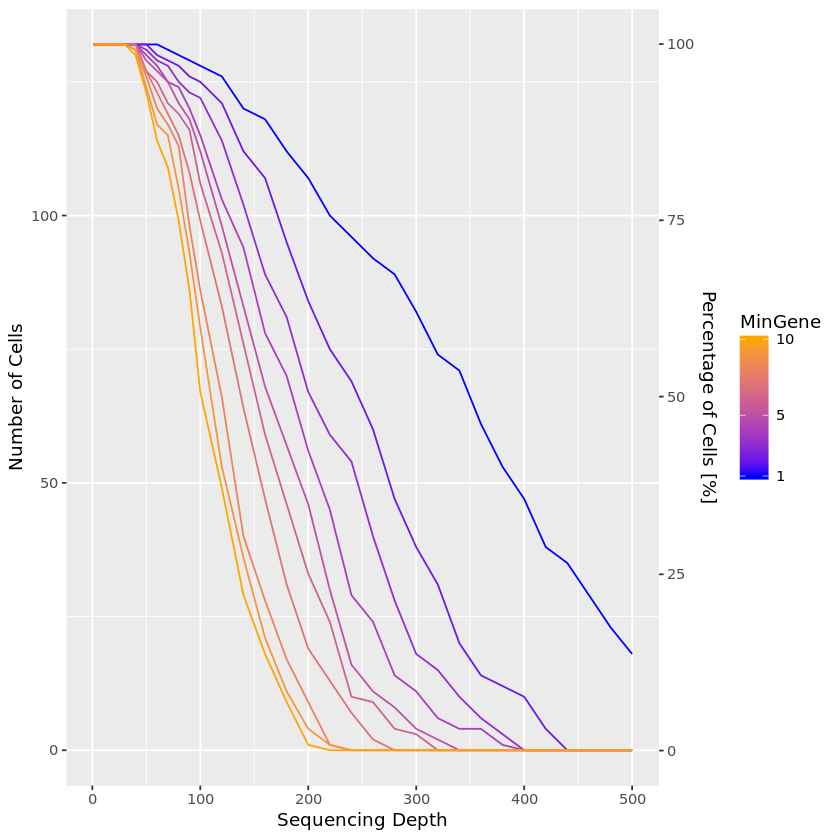

In [124]:
ranger1 <- append( seq(0,8,1), append(seq(10,29,5), append(seq(30,50,10), c(100) )))
total_genes <- dim(sce)[[1]]
total_cells <- dim(sce)[[2]]

ggplot(results, aes(x=SeqDep, y=NumGenes, colour=MinGene)
) + geom_line(aes(group=MinGene)
) + scale_x_log10(breaks=ranger1, limits=c(1,100)
) + scale_y_continuous(
    sec.axis = sec_axis(~./total_genes*100, name = "Percentage of Genes [%]",),
    breaks=seq(0,30000,2000)
) + xlab("Sequencing Depth") + ylab("Number of Genes"
) + scale_color_continuous(breaks = c(1,5,10), low = "blue", high = "orange")


ggplot(results, aes(x=SeqDep, y=NumCells, colour=MinGene)
) + geom_line(aes(group=MinGene)
) + scale_y_continuous(
    sec.axis = sec_axis(~./total_cells*100, name = "Percentage of Cells [%]",),
) + xlab("Sequencing Depth") + ylab("Number of Cells"
) + scale_color_continuous(breaks = c(1,5,10), low = "blue", high = "orange")


#plotQC(sce, type="high")

From this we can see that something,,,,

In [ ]:
Let us now evaluate #2